# Read dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('./dataset/Google_Stock_Price_Train.csv').values
test_data = pd.read_csv('./dataset/Google_Stock_Price_Test.csv').values

# parameter
input_days = 20
epochs = 500
batch_size = 250
offset = 0.

# Fix data string to float

In [2]:
# the data[4:6] must be fix
def str2float(data):
    length = len(data)
    for i in range(length):
        try:
            data[i] = data[i].replace(',', '')
        except AttributeError:
            data[i] = data[i]
    return np.asarray(data, dtype=np.float)
    
# fix all data in dataset
def fixStr2Float(dataset):
    shape = dataset.shape
    dataset_t = np.zeros((0, shape[-1]), np.float)
    for i, data in enumerate(dataset):
        dataset_t = np.append(dataset_t, np.expand_dims(str2float(data), axis=0), axis=0)
    return dataset_t

# trainsform
train_data_t = fixStr2Float(train_data[:, 1:])
test_data_t = fixStr2Float(test_data[:, 1:])

print(train_data_t.shape)
print(test_data_t.shape)

(1258, 5)
(20, 5)


# My own MinMaxScaler

In [3]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        self.__range = (data_max - data_min) * (1 + offset)
        self.__min = data_max - self.__range
        self.__max = data_min + self.__range
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale

# define create dataset

In [4]:
def createDataset_global(dataset, day_in=60, day_out=1):
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(dataset[i-day_in:i, :])
        y.append(dataset[i:i+day_out, :])
    return np.asarray(x), np.asarray(y)

def genQuteChange(dataset):
    return (dataset[1:] - dataset[:-1]) / dataset[:-1]

def createDataset_local(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(sc.getScalerData(dataset[i-day_in:i, :], offset=offset))
        y.append(sc.getTransformData(dataset[i:i+day_out, :]))
    return np.asarray(x), np.asarray(y)

def createDataset_mix(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    y_sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x_data = dataset[i-day_in:i, :]
        y_data = dataset[i:i+day_out, :]
        x_mean = np.mean(x_data)
        x.append(sc.getScalerData(x_data, offset=offset))
        y.append((y_data - x_mean) / x_mean)
    return (np.asarray(x), y_sc.getScalerData(np.asarray(y))), y_sc

# Create training dataset and testing dataset

In [5]:
# append to a big dataset total
dataset = np.append(train_data_t, test_data_t, axis=0)
test_count = len(test_data_t)

# Split dataset to Volume and Open
open_data = dataset[:, :1]
volume_data = dataset[:, -1:]

# use global norm to volume data (with offset)
volume_sc = MinMaxScaler()
volume_norm = volume_sc.getScalerData(volume_data, offset=0.05, feature_range=(0, 1))

# create dataset
volume_dataset = createDataset_global(volume_norm, day_in=input_days)
open_dataset, label_sc = createDataset_mix(dataset[:, :1], day_in=input_days, offset=offset)

# create total dataset
dataset_x = np.append(open_dataset[0], volume_dataset[0], axis=-1)
dataset_y = np.append(open_dataset[1], volume_dataset[1], axis=-1)

# split to train and test dataset
train_x = dataset_x[:-test_count]
train_y = dataset_y[:-test_count, :, :1]
test_x = dataset_x[-test_count-input_days:]
test_y = dataset_y[-test_count-input_days:, :, :1]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1238, 20, 2) (1238, 1, 1)
(40, 20, 2) (40, 1, 1)


# Create Model

In [6]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_days, 2), dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            10600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_______________________________________

# Training the model with Open data and Volume data

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'LSTM_04'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# get what we want
train_input = train_x
train_label = train_y
test_input = test_x
test_label = test_y
train_label = np.squeeze(train_label, axis=1)
test_label = np.squeeze(test_label, axis=1)

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=10)

# train the model
train = model.fit(train_input, train_label, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], 
                  validation_data=(test_input, test_label))

# save model
model.save('./model/' + name + '.h5')

Train on 1238 samples, validate on 40 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
1238/1238 [==============================] - 3s 2ms/sample - loss: 0.1215 - val_loss: 0.0094
Epoch 2/500
1238/1238 [==============================] - 0s 240us/sample - loss: 0.0422 - val_loss: 0.0252
Epoch 3/500
1238/1238 [==============================] - 0s 240us/sample - loss: 0.0233 - val_loss: 0.0081
Epoch 4/500
1238/1238 [==============================] - 0s 227us/sample - loss: 0.0198 - val_loss: 0.0159
Epoch 5/500
1238/1238 [==============================] - 0s 252us/sample - loss: 0.0137 - val_loss: 0.0056
Epoch 6/500
1238/1238 [==============================] - 0s 240us/sample - loss: 0.0127 - val_loss: 0.0079
Epoch 7/500
1238/1238 [==============================] - 0s 240us/sample - loss: 0.0105 - val_loss: 0.0041
Epoch 8/500
1238/1238 [==============================] - 0s 252us/sample - loss: 0.0099 - val_loss: 0.0044
Epoch 9/500
1238/1238 [=============================

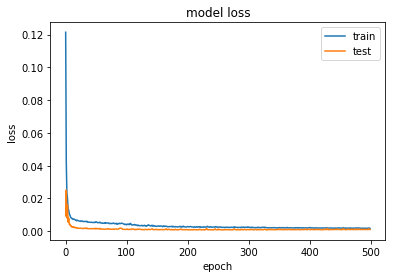

In [8]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
# local data
# model.load_weights('./model/LSTM_03_check_point/cp-{epoch:04d}.ckpt'.format(epoch=600))
testing_data = open_data[-test_count-input_days:]
output_prices = []
for i in range(test_count):
    sc = MinMaxScaler()
    test = testing_data[i:i+input_days]
    test_mean = np.mean(test)
    test = sc.getScalerData(test, offset=offset)
    output = np.squeeze(model.predict(np.append(np.expand_dims(test, axis=0), test_x[i:i+1, :, 1:2], axis=-1)), axis=0)
    output_prices.append(test_mean * (1 + label_sc.getInverseData(output)))

output_prices = np.asarray(output_prices)
print(output_prices.shape, output_prices)

(20, 1) [[781.9417 ]
 [782.86127]
 [787.5006 ]
 [787.8069 ]
 [794.125  ]
 [807.58093]
 [809.2654 ]
 [811.4591 ]
 [813.9439 ]
 [814.57385]
 [811.6305 ]
 [816.9376 ]
 [808.82794]
 [810.353  ]
 [812.68884]
 [821.36127]
 [828.14044]
 [837.3742 ]
 [844.6299 ]
 [823.43286]]


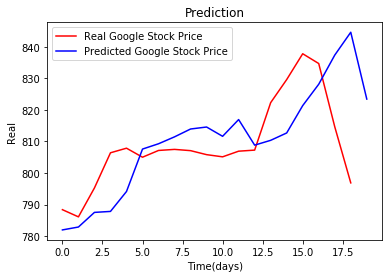

In [10]:
# Visualising the results
plt.plot(test_data_t[1:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()